In [6]:
# Import common libraries
import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint
import os

# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Import MNE-NIRS processing
import mne
from mne_nirs.channels import get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

In [53]:
def individual_analysis(bids_path):

    # Read data with annotations in BIDS format
    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, verbose=True, preload=False)
    raw_intensity = get_long_channels(raw_intensity, min_dist=0.01)
    
    raw_intensity.annotations.rename({'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'})

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(0.8)
    raw_od = temporal_derivative_distribution_repair(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo = raw_haemo.filter(0.02, 0.3,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)
    # Extract events but ignore those with
    # the word Ends (i.e. drop ExperimentEnds events)
    events, event_dict = events_from_annotations(raw_haemo, verbose=False)

    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-5, tmax=15,
                    reject=dict(hbo=200e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=0,
                    preload=True, verbose=False)

    return raw_haemo, epochs

In [54]:
all_evokeds = defaultdict(list)

subjects = os.listdir("../BIDS/")
for sub in subjects:
    if sub != ".DS_Store":
        # Create path to file based on experiment info
        f_path = f'../BIDS/{sub}/nirs/{sub}_task-AnonCom_nirs.snirf'
        
        # Analyse data and return both ROI and channel results
        raw_haemo, epochs = individual_analysis(f_path)
        
        # Save individual-evoked participant data along with others in all_evokeds
        for cidx, condition in enumerate(epochs.event_id):
            # print(epochs)
            all_evokeds[condition].append(epochs[condition].average())
            
pprint(all_evokeds)

Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS/sub-01/nirs/sub-01_task-AnonCom_nirs.snirf
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS/sub-02/nirs/sub-02_task-AnonCom_nirs.snirf


/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_20558/3998715079.py:14: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()
/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_20558/3998715079.py:14: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


defaultdict(<class 'list'>,
            {'Control': [<Evoked | 'Control' (average, N=6), -5 – 15 sec, baseline -5 – 0 sec, 36 ch, ~164 kB>,
                         <Evoked | 'Control' (average, N=6), -5 – 15 sec, baseline -5 – 0 sec, 36 ch, ~164 kB>],
             'Inflammatory': [<Evoked | 'Inflammatory' (average, N=6), -5 – 15 sec, baseline -5 – 0 sec, 36 ch, ~164 kB>,
                              <Evoked | 'Inflammatory' (average, N=6), -5 – 15 sec, baseline -5 – 0 sec, 36 ch, ~164 kB>],
             'Neutral': [<Evoked | 'Neutral' (average, N=6), -5 – 15 sec, baseline -5 – 0 sec, 36 ch, ~164 kB>,
                         <Evoked | 'Neutral' (average, N=6), -5 – 15 sec, baseline -5 – 0 sec, 36 ch, ~164 kB>],
             'Practice': [<Evoked | 'Practice' (average, N=6), -5 – 15 sec, baseline -5 – 0 sec, 36 ch, ~164 kB>,
                          <Evoked | 'Practice' (average, N=6), -5 – 15 sec, baseline -5 – 0 sec, 36 ch, ~164 kB>]})


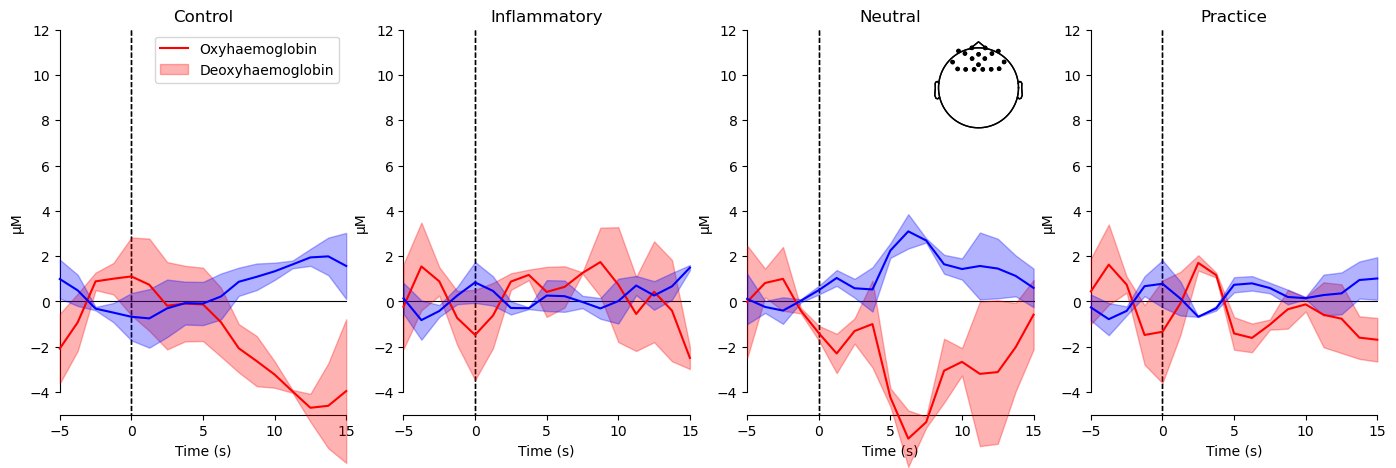

In [55]:
# Print figures

# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 12], hbr=[-5, 12])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds):
        plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                             picks=pick, axes=axes[idx], show=False,
                             colors=[color], legend=False, ylim=lims, ci=0.95,
                             show_sensors=idx == 2)
        axes[idx].set_title('{}'.format(evoked))
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])